Uplift modeling is one of the techniques or a branch of machine learning that tries to forecast class probability differences between group exposed to some action or therapy and control group (without that action or therapy).

This technique also allows to discover in research those groups of patients for which treatment was most beneficial, so it is commonly used not only in marketing campaigns or medical treatments but also in other customer services.


If you are simply building a Machine Learning model and executing promotion campaigns to the customers who are predicted to buy a product, for example, it is not efficient.

Some customers will buy a product anyway even without promotion campaigns (called "Sure things").

It is even possible that the campaign triggers some customers to churn (called "Do Not Disturbs" or "Sleeping Dogs").

The solution is Uplift Modeling.

### What is Uplift Modeling?


Uplift Modeling is a Machine Learning technique to find which customers (individuals) should be targeted ("treated") and which customers should not be targeted.

Uplift Modeling is also known as persuasion modeling, incremental modeling, treatment effects modeling, true lift modeling, or net modeling.

Applications of Uplift Modeling for business include:

- Increase revenue by finding which customers should be targeted for advertising/marketing campaigns and which customers should not.
- Retain revenue by finding which customers should be contacted to prevent churn and which customers should not.

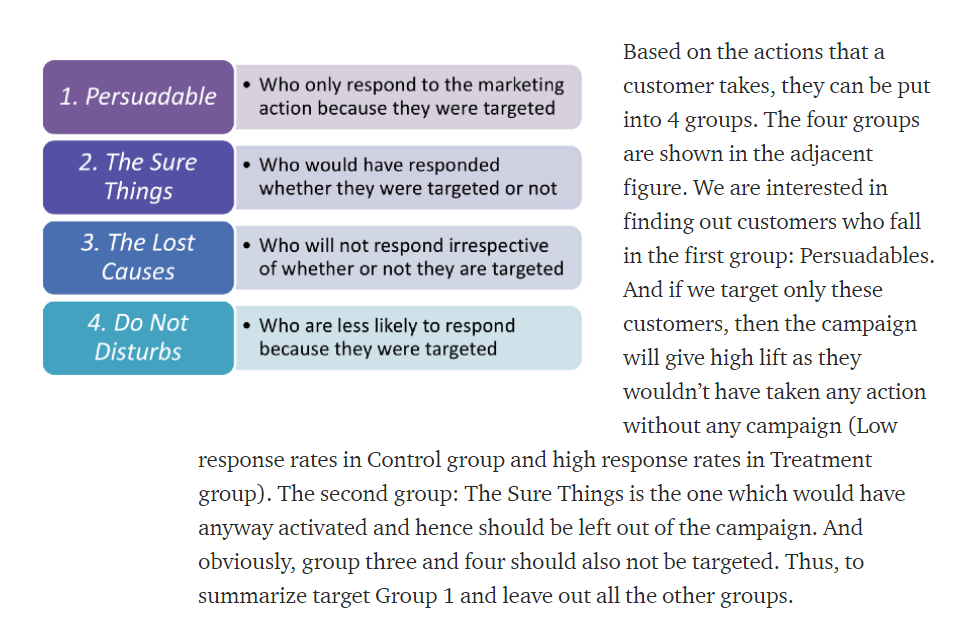

In [1]:
#ref https://www.vidora.com/ml-in-business/3-ways-to-evaluate-a-propensity-model/
#ref https://github.com/joshxinjie/Data_Scientist_Nanodegree/blob/master/starbucks_portfolio_exercise/Starbucks.ipynb
#ref https://medium.com/@abhayspawar/uplift-models-for-better-marketing-campaigns-part-1-b491292e4c80
#ref https://medium.com/@abhayspawar/uplift-models-for-better-marketing-campaigns-part-2-f04f90d84aef
#ref https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2

**Background Information**\
The dataset used in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

**Optimization Strategy**\
Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

**Incremental Response Rate (IRR)**\
IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (treatment) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (control).




**Net Incremental Revenue (NIR)**\
NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.



In [2]:
from itertools import combinations

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [26]:
# load in the data
train = pd.read_csv('starbucks.csv')
train.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [27]:
test = pd.read_csv('starbucks_test.csv')
test.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


**Defining the metric**

In [28]:
def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)

In [31]:
score(train,"Promotion")

(0.009454547819772702, -2334.5999999999995)

In [32]:
score(test,"Promotion")

(0.009593158278250108, -1132.1999999999998)

**Model Building**

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):




We can opt to send promotions to individuals with prostive lift values. Using this approach for this dataset, an irr of 1.42\% and an nlr of -\$47.40 is obtained for the validation set. On the other hand, the irr and nlr values for the test set is 1.54\% and \\$42.60 respectively. Such a drastic difference between the validation and test nlrs is certainly surprising. The test results does seem to suggest that this is could be a relatively good approach as well. Alternative models, new feature generation and alternative upsampling methods could be tried to improve the results. In addition, you can also choose to send promotions only to individuals with lift values above a certain percentile.

In [33]:
# encode Promotion as 0 or 1 indicator variable
train['treatment'] = np.where(train['Promotion'] == "Yes", 1, 0)
train.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [34]:
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [35]:
# up sample with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [36]:

eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=False, early_stopping_rounds=30)

C:\Users\ramya\Anaconda3\envs\py3tf2\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

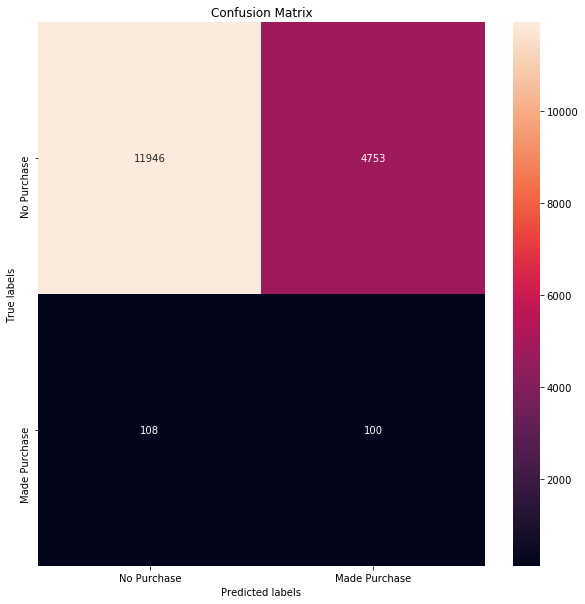

In [37]:
# confusion marix for the validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [38]:
test.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


**Calculating the Lift**

In [89]:
valid['treatment'] = 1.0
preds_treat = model.predict_proba(valid[features], ntree_limit=model.best_ntree_limit)

In [90]:
preds_treat

array([[0.59190464, 0.4080954 ],
       [0.45824307, 0.5417569 ],
       [0.565539  , 0.43446103],
       ...,
       [0.4811051 , 0.5188949 ],
       [0.45824307, 0.5417569 ],
       [0.45824307, 0.5417569 ]], dtype=float32)

In [91]:
valid['treatment'] = 0.0
preds_cont = model.predict_proba(valid[features], ntree_limit=model.best_ntree_limit)

In [92]:
lift = preds_treat[:,1] - preds_cont[:,1]

In [93]:
promotion = []
    
for prob in lift:
    if prob > 0:
        promotion.append('Yes')
    else:
        promotion.append('No')

promotion = np.array(promotion)

In [94]:
valid["Promotion"]=promotion
valid

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
6264,9346,No,0,3,18.012754,-1.511395,2,2,4,1,0.0
41822,62172,Yes,0,2,28.676557,-0.126150,2,3,3,2,0.0
8569,12768,No,0,0,28.817748,-1.511395,2,4,3,2,0.0
41228,61264,Yes,0,1,26.140783,-0.905350,2,1,4,2,0.0
24896,37024,Yes,0,1,32.346423,0.566472,1,2,3,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31179,46300,No,0,3,26.310883,-0.299306,1,3,1,1,0.0
17641,26264,Yes,0,2,24.402187,-1.078506,2,2,4,2,0.0
73097,109020,Yes,0,1,29.043276,1.518828,2,3,1,2,0.0
71261,106302,Yes,0,1,27.070219,-1.597972,2,3,3,2,0.0


In [103]:
score(valid,"Promotion")

(0.0021153213127796857, -951.5999999999999)

In [96]:
test['treatment'] = 1.0
preds_treat = model.predict_proba(test[features], ntree_limit=model.best_ntree_limit)

In [97]:
test['treatment'] = 0.0
preds_cont = model.predict_proba(test[features], ntree_limit=model.best_ntree_limit)

In [98]:
lift = preds_treat[:,1] - preds_cont[:,1]

In [99]:
promotion = []
    
for prob in lift:
    if prob > 0.0:
        promotion.append('Yes')
    else:
        promotion.append('No')

promotion = np.array(promotion)

In [100]:
test["Promotion"]=promotion
test

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,2,No,0,1,41.376390,1.172517,1,1,2,2,0.0
1,6,No,0,1,25.163598,0.653050,2,2,2,2,0.0
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2,0.0
3,10,Yes,0,2,28.529691,-1.078506,2,3,2,2,0.0
4,12,No,0,2,32.378538,0.479895,2,2,1,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
41645,126166,Yes,0,1,33.073275,-0.126150,2,2,2,2,0.0
41646,126174,Yes,0,0,32.065720,0.999361,2,3,2,1,0.0
41647,126176,No,1,3,27.691221,1.172517,2,2,1,2,0.0
41648,126177,Yes,0,2,32.306427,0.566472,1,2,4,1,0.0


In [101]:
score(test,"Promotion")

(0.0063774334873678284, -1562.0499999999997)